In this notebook we want to examine the effect of T1236C, T2677G and T3435C on patient survival. 
We use data from TCGA to create Kaplan Meier curves and perform a log rank test. 

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from Utils_MDR1 import *
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter 
from lifelines.statistics import logrank_test
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor


# Functions

In [36]:
''' 
Plots a Kaplan Meier survival curve and calculates the logrank test.
patients_with: a list of patients with the variant/ variants (case group).
patient_df: a dataframe with clinical information of the patients. 
''' 

def plot_KM_and_calc_logrank(patients_with: np.array, patient_df: pd.DataFrame, variant_name: str) -> None:
    
    ''' Fit the kaplan meier curves '''

    # the case group - with the mutation/s
    patient_df_with_mut = patient_df[patient_df['patient_uuid'].isin(patients_with)].copy()
    # the control group - with the mutation/s
    patient_df_without_mut = patient_df[~patient_df['patient_uuid'].isin(patients_with)].copy()

    #define parameters needed to plot the km curves - death status and time stamp
    T=patient_df_with_mut['days_alive']
    E=patient_df_with_mut['death_status']
    T1=patient_df_without_mut['days_alive']
    E1=patient_df_without_mut['death_status']
    num_patients_with = T.shape[0]
    num_patients_without = T1.shape[0]

    kmf = KaplanMeierFitter()
   # calculate the logrank_test
    results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
    pval = np.round(results.p_value,2)
    #test_statistic = np.round(results.test_statistic,2)
    
    #plot
    ax = plt.subplot(111)
    ax = kmf.fit(T, E, label=f"carriers group (n = {num_patients_with})").plot(ax=ax)
    ax = kmf.fit(T1, E1, label=f"non-carriers group (n = {num_patients_without})").plot(ax=ax)
    
    list_vars = variant_name.split("_")
    if len(list_vars) == 1: #only a single variant
        var_title = variant_name
    else:
        var_title = " , ".join(list_vars)

    plt.title(f"{var_title} (p = {pval})")

    plt.xlabel("Days from Diagnosis")
    plt.ylabel("Survival Probability")

    plt.savefig(f'../Figures/KM/km_curve_{variant_name}.png', bbox_inches = "tight", dpi=500)


# Main

In [37]:
# get info of the gene
gene = 'ENSG00000085563' #MDR1/ABCB1 gene
gene_name = "ABCB1"

#get all mutations of this gene from TCGA
cancer_muts_mdr1 = get_cancer_muts_cur_gene(gene_name) #get mutations of the cancerous cohort of the current gene
num_patients = len(cancer_muts_mdr1["case_id"].unique())
num_muts = cancer_muts_mdr1.shape[0]
print(f"There are {num_patients} patients with {num_muts} mutations in this gene")


There are 3677 patients with 7559 mutations in this gene


In [38]:
#create a df with all patients' clinical info
patient_df = pd.DataFrame()

rootdir = '/tamir2/cancer_proj/gdc_db/data/filtered_dec_2018/TCGA/'
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file == 'PtntInfoTble.txt': 
            path_to_file = os.path.join(subdir, file)
            patients_info_cur_cancertype = pd.read_csv(path_to_file)
            patient_df = pd.concat([patient_df, patients_info_cur_cancertype], sort =  True)


In [39]:
# define the "death_status" and "timestamp" atributes required for the KM curves

patient_df['death_status'] = patient_df['days_to_death'] > 0 #death_status == True for patients that have an int>0 in the days_to_death column 

# the time stamp value is defined as the last time we knew the vital status of the patient. meaning it is the 
# maximum value in the columns "days to followup", "days to know alive", "days to death". 
cols = [x for x in patient_df.columns if 'days_to_followup' in x or 'days_to_know_alive' in x] + ['days_to_death']
patient_df['days_alive'] = patient_df[cols].max(axis=1)  

# remove missing data
patient_df = patient_df[np.isfinite(patient_df.days_alive)] #removing people with no info on them in the relevant columns, we dont know anything about them that will help this model



## T1236C

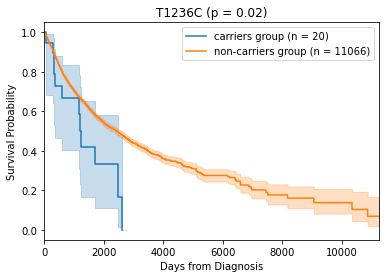

In [28]:
#variant info
cds_position = variant_info[1]["cds_position"]
change_to = variant_info[1]["change_to"]
variant_name = variant_info[1]["variant_name"]

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_1236 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()


#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_1236, patient_df, variant_name)


## T2677G

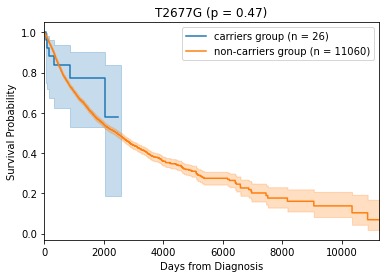

In [25]:
#variant info
cds_position = variant_info[2]["cds_position"]
change_to = variant_info[2]["change_to"]
variant_name = variant_info[2]["variant_name"]

#get list of patients with this mutation in TCGA
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_2677 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_2677, patient_df, variant_name)


## T3435C

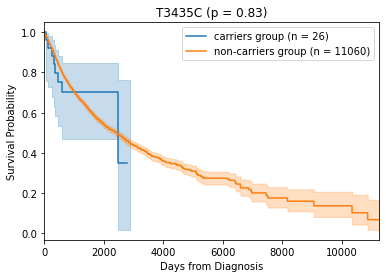

In [26]:
#variant info
cds_position = variant_info[3]["cds_position"]
change_to = variant_info[3]["change_to"]
variant_name = variant_info[3]["variant_name"]

#get list of patients with this mutation in TCGA
cur_position = cancer_muts_mdr1['CDS_position'].apply(lambda x: str(cds_position) in x)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"].apply(lambda x: reverse_complement(x) == change_to)
patients_with_mut_3435 = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_mut_3435, patient_df, variant_name)


## Haplotypes

In [132]:
## T1236C & T2677G

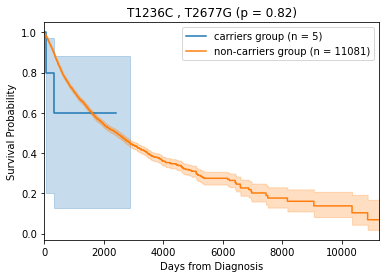

In [29]:
variant_name = "T1236C_T2677G"
patients_1236_2677 = [patient for patient in patients_with_mut_1236 if patient in patients_with_mut_2677]
plot_KM_and_calc_logrank(patients_1236_2677, patient_df, variant_name)


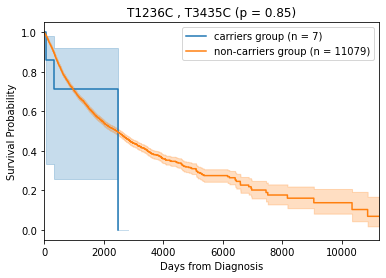

In [30]:
## T1236C & T3435C
variant_name = "T1236C_T3435C"
patients_1236_3435 = [patient for patient in patients_with_mut_1236 if patient in patients_with_mut_3435]
plot_KM_and_calc_logrank(patients_1236_3435, patient_df, variant_name)



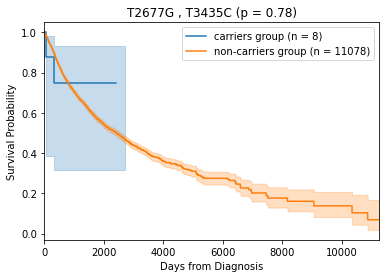

In [31]:
## T2677G & T3435C
variant_name = "T2677G_T3435C"
patients_2677_3435 = [patient for patient in patients_with_mut_2677 if patient in patients_with_mut_3435]
plot_KM_and_calc_logrank(patients_2677_3435, patient_df, variant_name)


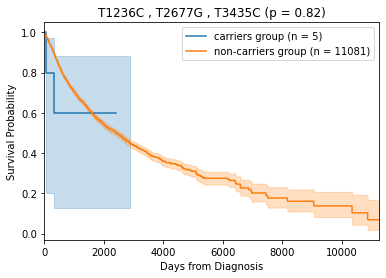

In [32]:
## T1236C & T2677G & T3435C
variant_name = "T1236C_T2677G_T3435C"
patients_1236_2677_3435 = [patient for patient in patients_2677_3435 if patient in patients_with_mut_1236]
plot_KM_and_calc_logrank(patients_1236_2677_3435, patient_df, variant_name)


In [ ]:
## T1236C | T2677G | T3435C
variant_name = "any_of_three"
patients_any = np.unique(list(patients_with_mut_1236) + list(patients_with_mut_2677) + list(patients_with_mut_3435))
#plot_KM_and_calc_logrank(patients_any, patient_df, variant_name)

In [145]:
#lets save a dictionary with the patients that have the mutations or the haplotypes. It can be useful for further analyses. 

patients_dict = {
    "T1236C": patients_with_mut_1236, "T2677G": patients_with_mut_2677, "T3435C": patients_with_mut_3435,
    "T1236C_T2677G": patients_1236_2677, "T1236C_T3435C": patients_1236_3435, "T2677G_T3435C": patients_2677_3435,
    "T1236C_T2677G_T3435C": patients_1236_2677_3435, "any_of_three": patients_any
}

with open(f"../Data/mutated_patients_dict.pickle",'wb') as f:
    pickle.dump(patients_dict, f)


## Chemotherapy recepients

In [33]:
# Get the list of patients who endured any type of chemotherapy treatment
chemo_patients = patient_df[~patient_df["chemotherapy"].isna()]["patient_uuid"].values # a list of patients who had one or more round of chemotherapy


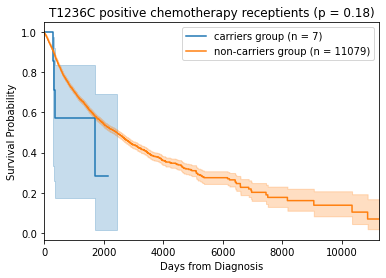

In [34]:
#T1236C

variant_name = "T1236C positive chemotherapy receptients"
patients = [patient for patient in patients_with_mut_1236 if patient in chemo_patients]
''' Plot the KM curve '''
plot_KM_and_calc_logrank(patients, patient_df, variant_name)


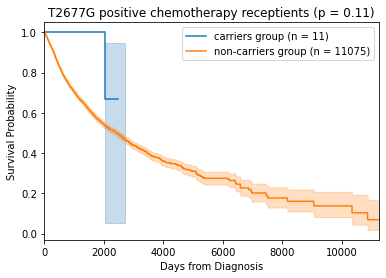

In [35]:
variant_name = "T2677G positive chemotherapy receptients"
patients = [patient for patient in patients_with_mut_2677 if patient in chemo_patients]
''' Plot the KM curve '''
plot_KM_and_calc_logrank(patients, patient_df, variant_name)


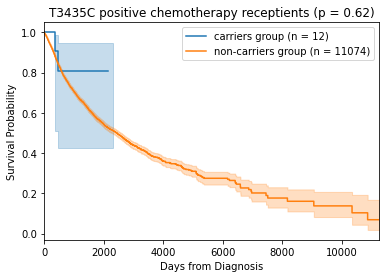

In [36]:
variant_name = "T3435C positive chemotherapy receptients"
patients = [patient for patient in patients_with_mut_3435 if patient in chemo_patients]
''' Plot the KM curve '''
plot_KM_and_calc_logrank(patients, patient_df, variant_name)


## Correlation or causation? 
To strengthen the hypothesis that T1236C *causes* the effect on survivability, we also check the effect of mutations correlated to it on survivability. 

In [37]:
# get the list of all mutations that patients with T1236C have. These are sorted by number of occurences. 
#for example: mut1 = 19 means that 19 out of 20 T1236C positive patients also have mut1. 

shared_muts = pd.read_pickle(f"../Data/muts_correlated_with_T1236C.pickle")
print(f"Correlated mutations:\n\n{shared_muts.head(n = 10)}")


Correlated mutations:

ENSG00000184956:chr11:1016789:1016789:T:A    19
ENSG00000184956:chr11:1016779:1016779:G:A    19
ENSG00000184956:chr11:1016800:1016800:G:A    17
ENSG00000184956:chr11:1016802:1016802:T:A    16
ENSG00000184956:chr11:1016842:1016842:T:G    15
ENSG00000184956:chr11:1016810:1016810:G:T    14
ENSG00000184956:chr11:1016818:1016818:A:G    14
ENSG00000184956:chr11:1016954:1016954:G:T    14
ENSG00000184956:chr11:1017898:1017898:T:G    13
ENSG00000184956:chr11:1016906:1016906:G:T    13
Name: mut_id, dtype: int64


In [39]:
#get only the highly correlated ones - mutations that over 75% of T1236C positive patients have 

highly_correlated_muts = shared_muts > 15
highly_correlated_muts = highly_correlated_muts[highly_correlated_muts].index.to_list()
print(f"There are {len(highly_correlated_muts)} mutations that are present in more than 75% of T1236C positive patients:")
print(highly_correlated_muts)


There are 4 mutations that are present in more than 75% of T1236C positive patients:
['ENSG00000184956:chr11:1016789:1016789:T:A', 'ENSG00000184956:chr11:1016779:1016779:G:A', 'ENSG00000184956:chr11:1016800:1016800:G:A', 'ENSG00000184956:chr11:1016802:1016802:T:A']


In [40]:
#notice that all the correlated mutations are in MUC6, a gene that has many mutations on TCGA. 

gene = 'ENSG00000184956' #MDR1/ABCB1 gene
gene_name = "MUC6"

#get all mutations of this gene from TCGA
cancer_muts_cur_gene = get_cancer_muts_cur_gene(gene_name) #get mutations of the cancerous cohort of the current gene


/tamir1/tal_g/ENV/co-trans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (19,20,21,22,28) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/tamir1/tal_g/ENV/co-trans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (118) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/tamir1/tal_g/ENV/co-trans/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (19,20,21,22,28,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


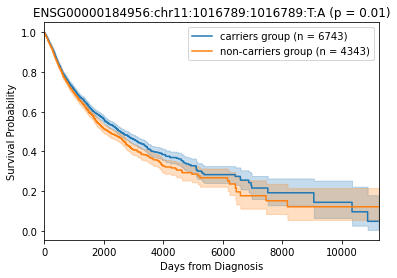

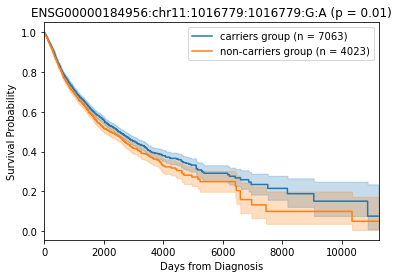

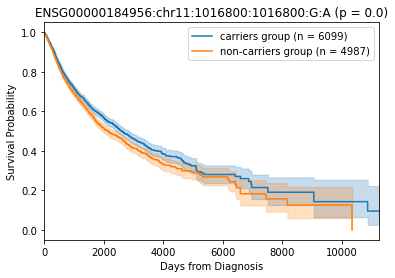

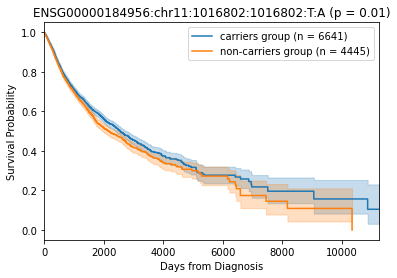

In [41]:
#for each mutation, plot the KM curve and calculate log-rank. 

for mut_id in highly_correlated_muts:

    #variant info
    _, _, start_pos, _, _, alt = mut_id.split(":")

    #get list of patients with this mutation in TCGA'
    cur_position = cancer_muts_cur_gene['Start_Position'] == int(start_pos)
    cur_alt = cancer_muts_cur_gene["Tumor_Seq_Allele2"] == alt
    patients_with_this_mut = cancer_muts_cur_gene[cur_position & cur_alt]["case_id"].unique()

    #Plot the KM curve
    plot_KM_and_calc_logrank(patients_with_this_mut, patient_df, mut_id)
    plt.show()
    
    # plt.savefig(f'../Figures/KM/km_curve_{mut_id}.png', bbox_inches = "tight", dpi=500)


In [42]:
#Lets also check specifically for MDR1 mutations.

indices_mdr1_muts = [i for i,name in enumerate(shared_muts.index) if "ENSG00000085563" in name] #get the rank of mutations in MDR1
highest_correlated_mdr1_mut = shared_muts[indices_mdr1_muts][:1]
mut_id = highest_correlated_mdr1_mut[:1].index[0]
num_appearances = highest_correlated_mdr1_mut[:1].values[0]
print(f"The most highly correlated MDR1 mutation is {mut_id}.\nIt appears in {num_appearances} T1236C positive patients")


The most highly correlated MDR1 mutation is ENSG00000085563:chr7:87549827:87549827:A:G.
It appears in 7 T1236C positive patients


Results
   t 0: -1
   test: logrank
   alpha: 0.95
   null distribution: chi squared
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.62232 |              0.243 |  Cannot Reject Null |       False       


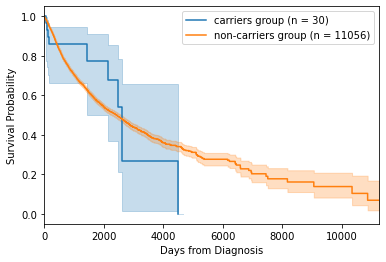

In [251]:
#variant info
_, _, start_pos, _, _, alt = mut_id.split(":")

#get list of patients with this mutation in TCGA'
cur_position = cancer_muts_mdr1['Start_Position'] == int(start_pos)
cur_alt = cancer_muts_mdr1["Tumor_Seq_Allele2"] == alt
patients_with_this_mut = cancer_muts_mdr1[cur_position & cur_alt]["case_id"].unique()

#Plot the KM curve
plot_KM_and_calc_logrank(patients_with_this_mut, patient_df, mut_id)
plt.show()


We can see that the mutations that are correlated with T1236C (probably because they are very common) 
are actually correlated with *better* prognosis, unlike T1236C.  
They are all in the MUC6 gene, unknown to be related to MDR1 regulation. 
The mutations that is most highly correlated with T1236C on the MDR1 gene is "ENSG00000085563:chr7:87549827:87549827:A:G" and it is not correlated with patient survivability. 

## Control for the number of variants 
make sure that the patients with T1236C, T2677G and T3435C have on average the same amount of mutations as other TCGA patients

## Functions

In [76]:
# Build an index of the relevant CSV files - maps a cancer type to the relevant files
def build_file_index(root_path: str) -> dict:
    file_index = {}
    for root, dirs, files in os.walk(root_path):
        for project_file in files: #name is the cancer type
            if "maf" in project_file:
                project_name = project_file.split(".")[0]
                gene_folder = os.path.basename(root)
                path_to_folder = os.path.join(root_path, gene_folder, project_file)
                if project_name not in file_index:
                    file_index[project_name] = []
                file_index[project_name].append(path_to_folder)
    return(file_index)

In [77]:
''' Get the csv file with all TCGA mutations in this gene and cancer type and create a df with the mutations of a single patient '''
def process_csv_file(path_to_df: str, case_id: str) -> pd.DataFrame:
    num_rows_to_skip = get_rows_to_skip(path_to_df)
    temp_df = pd.read_csv(path_to_df, sep="\t", skiprows=num_rows_to_skip)
    return(temp_df[temp_df["case_id"] == case_id].shape[0])


In [78]:
''' Get all the TCGA mutations of a single patient '''
def get_num_muts_single_patient(case_id: str, patient_cancer_type: str, file_index: dict) -> int:
    counter = 0
    if patient_cancer_type in file_index:
        csv_files = file_index[patient_cancer_type]
        with ProcessPoolExecutor() as executor:
            futures = []
            for csv_file in csv_files:
                futures.append(executor.submit(process_csv_file, csv_file, case_id))
            counter = sum(f.result() for f in futures)
    return(counter)


In [79]:
def check_if_balanced(num_muts_patients, people_with_variant, people_without_variant):
    
    num_muts_with = []
    num_muts_without = []
    
    for patient, num_muts in num_muts_patients.items():
        if patient in people_with_variant:
            num_muts_with.append(num_muts)
        if patient in people_without_variant:
            num_muts_without.append(num_muts)
            
    #check whether the samples of the mutated and unmutated group (the number of mutations per patient) 
    #come from the same distribution or not
    return(stats.ks_2samp(np.array(num_muts_with), np.array(num_muts_without)))
    

## Main

In [ ]:
''' our files are originized like this: TCGA/gene_name/cancer_type in the file system. We have many genes 
#and the process of opening all files takes a long time. We save time by creating a file index, this way we can 
#open only the ones we currenly need '''

root_path = "../../../../../tamir2/cancer_proj/gdc_db/data/filtered_feb_2021/AllGenes/"
file_index = build_file_index(root_path)

#save the file index
with open(f"../Data/paths_to_cancer_type.pickle",'wb') as f:
    pickle.dump(file_index, f)


In [ ]:
''' creare a dictionary where the keys are patien case_ids and the values are there total number of mutations in 
all genes '''

list_patients = list(patient_df["patient_uuid"].unique())
patients_and_types = pd.read_pickle("../Data/TCGA_patients_and_cancer_types_df.pickle") #get a dict[patient] -> cancer tpye

#num_muts_per_patient = {}
for patient in list_patients:
    try:
        if patient not in num_muts_per_patient.keys():
            patient_cancer_type = patients_and_types[patients_and_types["case_id"] == patient]["Cancer_Type"].values[0]
            # Call the function with the optimized code
            num_muts = get_num_muts_single_patient(patient, patient_cancer_type, file_index)
            num_muts_per_patient[patient] = num_muts
    except:
        pass

with open(f"../Data/num_muts_per_patient.pickle",'wb') as f:
    pickle.dump(num_muts_per_patient, f)


In [93]:
''' Check whether the mutational burden is balanced in the mutated and unmutated groups '''

# get a list of patients with one of the variants
patients_with_mdr1_muts = pd.read_pickle(f"../Data/mutated_patients_dict.pickle")
patients_T1236C = patients_with_mdr1_muts["T1236C"]
patients_T2677G = patients_with_mdr1_muts["T2677G"]
patients_T3435C = patients_with_mdr1_muts["T3435C"]

# get the dictionary that holds the amount of mutations per patient in TCGA. 
num_muts_patients = pd.read_pickle("../Data/num_muts_per_patient.pickle")

'''T1236C '''
patients_witout_T1236C = [patient for patient in num_muts_patients.keys() if patient not in patients_T1236C]
res = check_if_balanced(num_muts_patients, patients_T1236C, patients_witout_T1236C)
print(f"For variant T1236C the result of the KS test is:\n{res}")

'''T2677G '''
patients_witout_T2677G = [patient for patient in num_muts_patients.keys() if patient not in patients_T2677G]
res = check_if_balanced(num_muts_patients, patients_T2677G, patients_witout_T2677G)
print(f"For variant T2677G the result of the KS test is:\n{res}")

'''T3435C '''
patients_witout_T3435C = [patient for patient in num_muts_patients.keys() if patient not in patients_T3435C]
res = check_if_balanced(num_muts_patients, patients_T3435C, patients_witout_T3435C)
print(f"For variant T3435C the result of the KS test is:\n{res}")

For variant T1236C the result of the KS test is:
Ks_2sampResult(statistic=0.28256377922203896, pvalue=0.06693094678266699)
For variant T2677G the result of the KS test is:
Ks_2sampResult(statistic=0.3416219323721993, pvalue=0.003340695980463123)
For variant T3435C the result of the KS test is:
Ks_2sampResult(statistic=0.45543866984224163, pvalue=2.317601294341708e-05)


In [94]:
''' We can see that the groups are do not have balanced mutational burden. Why? 
Some of the TCGA patients go through WGS (tens-of-thousands of mutations) while most do through WES 
(thousands of mutations). All three mutations have several WGS patients in the group. 
Let remove WGS patients from all groups and see if we still get the same results for the survival analysis. '''

#keep only WES patients
thresh = 10000

allowed_T1236C = []
allowed_not_T1236C = []

allowed_T2677G = []
allowed_not_T2677G = []

allowed_T3435C = []
allowed_not_T3435C = []

for patient, num_muts in num_muts_patients.items():
    #T1236C
    if patient in patients_T1236C:
        if num_muts < thresh:
            allowed_T1236C.append(patient)
    else:
        if num_muts < thresh:
            allowed_not_T1236C.append(patient)
    #T2677G
    if patient in patients_T2677G:
        if num_muts < thresh:
            allowed_T2677G.append(patient)
    else:
        if num_muts < thresh:
            allowed_not_T2677G.append(patient)
    #T3435C
    if patient in patients_T3435C:
        if num_muts < thresh:
            allowed_T3435C.append(patient)
    else:
        if num_muts < thresh:
            allowed_not_T3435C.append(patient)



In [100]:
''' Check whether the mutational burden is now balanced in the mutated and unmutated groups '''

'''T1236C '''
res = check_if_balanced(num_muts_patients, allowed_T1236C, allowed_not_T1236C)
print(f"For variant T1236C the result of the KS test is:\n{res}")

'''T2677G '''
res = check_if_balanced(num_muts_patients, allowed_T2677G, allowed_not_T2677G)
print(f"For variant T2677G the result of the KS test is:\n{res}")

'''T3435C '''
res = check_if_balanced(num_muts_patients, allowed_T3435C, allowed_not_T3435C)
print(f"For variant T3435C the result of the KS test is:\n{res}")

For variant T1236C the result of the KS test is:
Ks_2sampResult(statistic=0.21300462913123053, pvalue=0.4563803357524434)
For variant T2677G the result of the KS test is:
Ks_2sampResult(statistic=0.36615454567209893, pvalue=0.011545373841004064)
For variant T3435C the result of the KS test is:
Ks_2sampResult(statistic=0.3611152976639035, pvalue=0.02965779430811935)


### Make sure T1236C is still significant in the balanced scenario

Text(0, 0.5, 'Survival Probability')

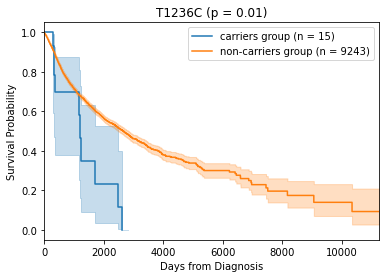

In [107]:
''' Fit the kaplan meier curves '''

# the case group - with the mutation/s
patient_df_with_mut = patient_df[patient_df['patient_uuid'].isin(allowed_T1236C)].copy()
# the control group - with the mutation/s
patient_df_without_mut = patient_df[patient_df['patient_uuid'].isin(allowed_not_T1236C)].copy()

#define parameters needed to plot the km curves - death status and time stamp
T=patient_df_with_mut['days_alive']
E=patient_df_with_mut['death_status']
T1=patient_df_without_mut['days_alive']
E1=patient_df_without_mut['death_status']
num_patients_with = T.shape[0]
num_patients_without = T1.shape[0]

kmf = KaplanMeierFitter()
# calculate the logrank_test
results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
pval = np.round(results.p_value,2)
#test_statistic = np.round(results.test_statistic,2)

#plot
ax = plt.subplot(111)
ax = kmf.fit(T, E, label=f"carriers group (n = {num_patients_with})").plot(ax=ax)
ax = kmf.fit(T1, E1, label=f"non-carriers group (n = {num_patients_without})").plot(ax=ax)

variant_name = "T1236C"
list_vars = variant_name.split("_")
if len(list_vars) == 1: #only a single variant
    var_title = variant_name
else:
    var_title = " , ".join(list_vars)

plt.title(f"{var_title} (p = {pval})")

plt.xlabel("Days from Diagnosis")
plt.ylabel("Survival Probability")